In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# file = "/content/drive/MyDrive/Data sorted.zip"

# import zipfile
# with zipfile.ZipFile(file, 'r') as zip_ref:
#     zip_ref.extractall("/content/drive/MyDrive/Data sorted")


In [2]:
import tensorflow as tf
import os
from shutil import copyfile
import numpy as np
from sklearn.model_selection import train_test_split
print("Tensorflow version: ", tf.__version__)

Tensorflow version:  2.8.2


Get images as 40X

In [3]:
images_benign = []
images_malignant = []

source_benign = "/content/drive/MyDrive/Data sorted/Data sorted/40X/Benign"
source_malignant = "/content/drive/MyDrive/Data sorted/Data sorted/40X/Malignant"

for image in os.listdir(source_benign):
    #print(image)
    current_image = os.path.join(source_benign,image)
    img = tf.keras.preprocessing.image.load_img(current_image, target_size=(150, 150))
    array = tf.keras.preprocessing.image.img_to_array(img)
    images_benign.append(array)
    
for image in os.listdir(source_malignant):
    current_image = os.path.join(source_malignant,image)
    img = tf.keras.preprocessing.image.load_img(current_image, target_size=(150, 150))
    array = tf.keras.preprocessing.image.img_to_array(img)
    images_malignant.append(array)    
    
print("Loaded 40X Benign Images: ",len(images_benign))
print("Loaded 40X Malignant Images: ",len(images_malignant))

Loaded 40X Benign Images:  623
Loaded 40X Malignant Images:  1369


Get Labels

In [4]:
# Create labels
y_benign = np.zeros(len(images_benign))
y_malignant = np.ones(len(images_malignant))
y_labels = np.concatenate((y_benign, y_malignant), axis = 0)
print("total labels: ",len(y_labels))

# Merge data 
X_main = np.concatenate((images_benign, images_malignant), axis = 0)
print("X_main shape: ", X_main.shape)

total labels:  1992
X_main shape:  (1992, 150, 150, 3)


In [5]:
y_labels

array([0., 0., 0., ..., 1., 1., 1.])

In [6]:
from keras.utils.np_utils import to_categorical
y = to_categorical(y_labels, num_classes= 2)
print(y)

[[1. 0.]
 [1. 0.]
 [1. 0.]
 ...
 [0. 1.]
 [0. 1.]
 [0. 1.]]


In [7]:
x_train, x_test, y_train, y_test = train_test_split(X_main, y,test_size=0.2, random_state=7788,
                                                    shuffle=True,stratify=y)

In [ ]:
# print(np.sum(y,axis=0))
# print(np.sum(y_test))

In [8]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator


#Add our data augmentation paramterers to image data generator
train_datagen = ImageDataGenerator(rescale = 1./255,
                                  rotation_range=60,
                                  width_shift_range = 0.2,
                                  height_shift_range = 0.2,
                                  shear_range = 0.2,
                                  zoom_range = 0.2,
                                  horizontal_flip = True,
                                   
                                  #preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input
                                   )

#Note that the validation data should not be augmented!!!
test_datagen = ImageDataGenerator(rescale = 1/255,
                                  #preprocessing_function=tf.keras.applications.inception_resnet_v2.preprocess_input
                                  )

#Flow training images in batches using train datagen generator
train_generator = train_datagen.flow(x_train,
                                     y_train,
                                     batch_size = 32,
                                     shuffle=True,
                                     seed = 7788)

# Flow validation images in batches using test_datagen generator
validation_generator =  test_datagen.flow(x_test,
                                     y_test,
                                     batch_size = 8,
                                     shuffle=True,
                                     seed = 7788)

In [9]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
import keras.backend as K

tf.random.set_seed(7788)

early_stopping = EarlyStopping(monitor='recall',patience=12, restore_best_weights=True)#

reduce_lr = ReduceLROnPlateau(monitor='recall', factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=1)

model_checkpoint = ModelCheckpoint(monitor='recall', 
                             filepath='./cnn_model_checkpoint.h5', 
                             save_best_only=True)

callbacks = [early_stopping,reduce_lr,model_checkpoint]


def precision(y_true, y_pred): #taken from old keras source code
     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
     precision = true_positives / (predicted_positives + K.epsilon())
     return precision
def recall(y_true, y_pred): #taken from old keras source code
     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
     recall = true_positives / (possible_positives + K.epsilon())
     return recall

Train standard CNN+DNN model

In [ ]:
# from tensorflow.keras import Model
# from tensorflow.keras import layers
# from tensorflow.keras.optimizers import RMSprop

# #Sequential API
# # model = tf.keras.models.Sequential([
# #     tf.keras.layers.Conv2D(16, (3,3), activation='relu', input_shape=(150, 150, 3)),
# #     tf.keras.layers.MaxPooling2D(2,2),
# #     tf.keras.layers.Conv2D(32, (3,3), activation='relu'),
# #     tf.keras.layers.MaxPooling2D(2,2), 
# #     tf.keras.layers.Conv2D(64, (3,3), activation='relu'), 
# #     tf.keras.layers.MaxPooling2D(2,2),
# #     tf.keras.layers.Flatten(), 
# #     tf.keras.layers.Dense(512, activation='relu'), 
# #     tf.keras.layers.Dense(2, activation='softmax')  
# # ])

# #Functional API
# input_layer = tf.keras.Input(shape=(150, 150,3))
# x = tf.keras.layers.Conv2D(16, (3,3), activation='relu')(input_layer)
# x = tf.keras.layers.MaxPooling2D(2,2)(x)
# x = tf.keras.layers.Conv2D(32, (3,3), activation='relu')(x)
# x = tf.keras.layers.MaxPooling2D(2,2)(x)
# x = tf.keras.layers.Conv2D(64, (3,3), activation='relu')(x)
# x = tf.keras.layers.MaxPooling2D(2,2)(x)
# x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.Dense(512, activation='relu')(x)
# output_layer = tf.keras.layers.Dense(2, activation='softmax')(x)

# model = Model(inputs=input_layer, outputs=output_layer)


# optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)
# optimizer5 = tf.keras.optimizers.Adagrad(learning_rate=0.0005, initial_accumulator_value=0.1, epsilon=1e-07,name='Adagrad')

# model.compile(optimizer=optimizer2, loss='categorical_crossentropy', metrics=[recall,'accuracy'])

# model.fit(train_generator,
#                               epochs=10,
#                               #steps_per_epoch=391,
#                               verbose=1,
#                               validation_data=validation_generator,
#                               #validation_steps=196,
#                               callbacks=[callbacks]
#                        )

<b>Initiate pretrained network</b>

In [10]:
import tensorflow as tf
from tensorflow.keras.applications.xception import Xception
from tensorflow.keras.applications.inception_resnet_v2 import InceptionResNetV2
from tensorflow.keras import Model
from tensorflow.keras import layers


Pre_trained_model = InceptionResNetV2(
                              input_shape = (150,150,3),
                              include_top = False, #This tells Keras not to download the fully connected layers of the pretrained model. This is because the top layer (fully connected layers) does the final classification.
                              weights = 'imagenet') #We are loading weights that were trained on imagenet dataset

Pre_trained_model.summary()

219070464/219055592 [==============================] - 1s 0us/step
Model: "inception_resnet_v2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 74, 74, 32)   864         ['input_1[0][0]']                
                                                                                                  
 batch_normalization (BatchNorm  (None, 74, 74, 32)  96          ['conv2d[0][0]']                 
 alization)                                                                                       
             

In [12]:
import tensorflow as tf
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
import keras.backend as K

tf.random.set_seed(7788)
np.random.seed(7788)

early_stopping = EarlyStopping(monitor='loss',patience=6, restore_best_weights=True)#

reduce_lr = ReduceLROnPlateau(monitor='loss', factor=0.2,
                              patience=2, min_lr=10e-15,
                              verbose=1)

model_checkpoint = ModelCheckpoint(monitor='loss', 
                             filepath='./cnn_model_checkpoint.h5', 
                             save_best_only=True)

callbacks = [early_stopping,reduce_lr,model_checkpoint]


def precision(y_true, y_pred): #taken from old keras source code
     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
     predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
     precision = true_positives / (predicted_positives + K.epsilon())
     return precision
def recall(y_true, y_pred): #taken from old keras source code
     true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
     possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
     recall = true_positives / (possible_positives + K.epsilon())
     return recall


for layer in Pre_trained_model.layers:
 
    layer.trainable = False

# flagous = False
# for layer in Pre_trained_model.layers:

#     if layer.name == "conv2d_155":
#         flagous = True
    
#     if flagous == False:
#       layer.trainable = False

#     if flagous == True:
#       layer.trainable = True

last_layer = Pre_trained_model.get_layer('conv2d_177')

print('last layer output shape: ', last_layer.output_shape)

last_output = last_layer.output

x = tf.keras.layers.Conv2D(64, (3,3), activation='relu',padding='same')(last_output)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Flatten()(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)
x = tf.keras.layers.Dense(1024, activation='relu')(x)
x = tf.keras.layers.Dropout(0.2)(x)

x = tf.keras.layers.Dense(2, activation='softmax')(x)

model1 = Model(Pre_trained_model.input,x)

optimizer2 = tf.keras.optimizers.Adam(learning_rate=0.002, beta_1=0.9, beta_2=0.999, epsilon=1e-07, amsgrad=False)

model1.compile(optimizer=optimizer2, loss='categorical_crossentropy', metrics=[recall,'accuracy'])

history = model1.fit(train_generator,
                              epochs=50,
                              #steps_per_epoch=391,
                              verbose=1,
                              validation_data=validation_generator,
                              #validation_steps=196,
                              callbacks=[callbacks]
                       )

last layer output shape:  (None, 3, 3, 224)
Epoch 1/50
50/50 [==============================] - 36s 335ms/step - loss: 0.6012 - recall: 0.7013 - accuracy: 0.7012 - val_loss: 0.5447 - val_recall: 0.6936 - val_accuracy: 0.6942 - lr: 0.0020
Epoch 2/50
50/50 [==============================] - 12s 242ms/step - loss: 0.5194 - recall: 0.7524 - accuracy: 0.7520 - val_loss: 0.4960 - val_recall: 0.7625 - val_accuracy: 0.7619 - lr: 0.0020
Epoch 3/50
50/50 [==============================] - 12s 239ms/step - loss: 0.4944 - recall: 0.7665 - accuracy: 0.7659 - val_loss: 0.5081 - val_recall: 0.7821 - val_accuracy: 0.7820 - lr: 0.0020
Epoch 4/50
50/50 [==============================] - 10s 208ms/step - loss: 0.5013 - recall: 0.7758 - accuracy: 0.7759 - val_loss: 0.4806 - val_recall: 0.7871 - val_accuracy: 0.7870 - lr: 0.0020
Epoch 5/50
50/50 [==============================] - 12s 239ms/step - loss: 0.4891 - recall: 0.7730 - accuracy: 0.7734 - val_loss: 0.4756 - val_recall: 0.7746 - val_accuracy: 0.7744

Define functions to make prediction and classification

In [14]:
def Classify(model, path,transform):
    
    image_storage = []
    predictions = list()
    pred = ""
    
    if transform == True:
        
        for item in path:
            #We are loading path folder with images that needs to be transformed
            img = tf.keras.preprocessing.image.load_img(item, target_size=(150, 150))
            image_storage = tf.keras.preprocessing.image.img_to_array(img)
            image_storage = np.array([image_storage])
            predictions.append(image_storage)

        predictions = np.squeeze(predictions)
        pred = model.predict(train_datagen.flow(predictions))
        pred = np.squeeze(pred)
    
    else:
        for item in path:
            #We are getting already transformed images
            predictions.append(item)

        predictions = np.squeeze(predictions)
        pred = model.predict(train_datagen.flow(predictions))
    
    return pred

def Classify_image(model,item):

    import matplotlib.pyplot as plt
    fig, ax = plt.subplots(1,1)
    fig.set_size_inches(23,5)

    img = tf.keras.preprocessing.image.load_img(item, target_size=(150, 150))
    image_storage = tf.keras.preprocessing.image.img_to_array(img)
    image_storage = np.array([image_storage])
    

    pred = model.predict(train_datagen.flow(image_storage))
    pred = np.squeeze(pred)
    print("pred: ", pred)
    pred = np.argmax(pred,axis=0)

    image_predict = plt.imread(item)
    ax.imshow(image_predict)
    ax.set_title("Loaded image")
    ax.axis('off')

    if pred == 1:
      print("\ntumor is malignant\n")
    else:
      print("\ntumor is benign\n")  
    

In [16]:
import pandas as pd
from sklearn.metrics import classification_report
y_pred_pr = Classify(model1,x_test,False)
print("probabilities \n", y_pred_pr[:2])
y_pred = np.argmax(y_pred_pr[:2],axis=1)
print("classification \n", y_pred)

probabilities 
 [[0.51679647 0.4832036 ]
 [0.1635843  0.8364157 ]]
classification 
 [0 1]


By Classify function we get probabilities of benign or malignant cases, this has to be followingly processed to get 0 or 1 via np.argmax function

In [17]:
y_pred = np.argmax(y_pred_pr,axis=1)
print(np.sum(y_pred))
y_pred
# print("probabilities:\n ",y_pred_pr)
# print("\nclassification: ",y_pred)

296


array([0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 1,
       0, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 1,
       0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 1, 0, 1, 0, 1,
       1, 1, 0, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 1, 0, 1, 0, 0, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0,
       1, 0, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1,
       1, 1, 1, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 0, 1, 0,
       1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 0, 0, 1,
       0, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 1, 0, 1, 1, 1, 0,
       1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0,

In [19]:
y_pred_pr = Classify(model1,x_test,False)
y_pred = np.argmax(y_pred_pr,axis=1)
# print("probabilities:\n ",y_pred_pr)
# print("\nclassification: ",y_pred)

**Make predictions on test set and Generate Classification Report**

In [24]:
import pandas as pd
from sklearn.metrics import classification_report

y_pred_pr = Classify(model1,x_test,False)

y_pred = np.argmax(y_pred_pr,axis=1)

y_true = np.argmax(y_test, axis=1)
report = classification_report(y_true,y_pred,output_dict=True)
classification_report_df = pd.DataFrame(report).T
classification_report_df

,precision,recall,f1-score,support
0,0.239583,0.184000,0.208145,125.000000
1,0.663366,0.733577,0.696707,274.000000
accuracy,0.561404,0.561404,0.561404,0.561404
macro avg,0.451475,0.458788,0.452426,399.000000
weighted avg,0.530602,0.561404,0.543649,399.000000


Get Additional Metrics

In [25]:
#Sensitivity Se - Recall: TP/TP+FN
#The Sensitivity is calculated as the number of diseased correctly classified divided by all diseased individuals

#Specificity Sp TN/TN+FP
#The specificity is calculated as the number of non-diseased correctly classified divided by all non-diseased individuals

#positive predictive value - precission: TP/TP+FP
#It is the ratio of patients truly diagnosed as positive to all those who had positive test results 
#(including healthy subjects who were incorrectly diagnosed as patient). This characteristic can predict how likely it is 
#for someone to truly be patient, in case of a positive test result.

#diagnostic odds ratio (tp*tn) / (fp*fn)
#In medical testing with binary classification, the diagnostic odds ratio (DOR) is a measure of the effectiveness of a diagnostic test. 
#It is defined as the ratio of the odds of the test being positive if the subject has a disease relative to the odds of the test 
#being positive if the subject does not have the disease. DOR expresses the ratio of the product of TP and TN to the 
#product of FP and FN. It is clear that DOR will become infinity when the related classifier is perfect.
#if < 1 - improper result, negative value of model is more commonly addressed to disease patient, positive value is more commonly addressed to non diseased patient
#if > 1 - higher the value better the model

#Kappa 
#Kappa is used for consistency checking, and its value is in the range of [−1, 1]. It can be divided into six groups representing the following 
#consistency levels: −1~0.0 (poor), 0.0~0.20 (slight), 0.21~0.40 (fair), 0.41~0.60 (moderate), 0.61~0.80 (substantial), and 0.81~1 (almost perfect) 


#F1 measure (F1)
#AUC
#Kappa criteria
#Macro-F1, Micro-F1, 
#image level test accuracy (ACC_IL)
#patient level test accuracy (ACC_PL)

#It is reported that a diagnosis system is reliable if Se> = 80%, Sp> = 95%, PPV> = 95%, and DOR> = 100

In [43]:
from sklearn.metrics import confusion_matrix
tn, fp, fn, tp = confusion_matrix(y_true, y_pred).ravel()
specificity = tn / (tn+fp)
print("TN: ",tn)
print("FP: ",fp)
print("FN: ",fn)
print("TP: ",tp)
print("\nSensitivity (Recall): ", tp/(tp+fn))
print("Specificity (Sp): ", tn / (tn+fp))
print("Positive predictive value (precission): ", tp / (tp+fp))
print("Diagnostic Odd Ratio (DOR): ", (tp*tn) / (fp*fn))

TN:  23
FP:  102
FN:  73
TP:  201

Sensitivity (Recall):  0.7335766423357665
Specificity (Sp):  0.184
Positive predictive value (precission):  0.6633663366336634
Diagnostic Odd Ratio (DOR):  0.620870265914585


**Classify Image**

pred:  [0.41032112 0.5896789 ]

tumor is malignant



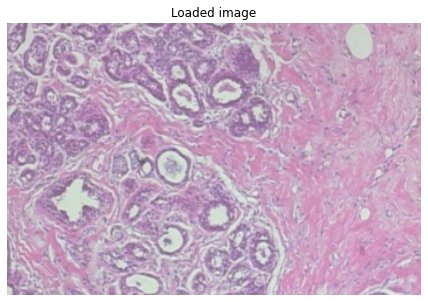

In [36]:
Classify_image(model1,"/content/drive/MyDrive/Data sorted/Data sorted/40X/Holdout set/SOB_B_A-14-22549AB-40-016_benign.png")

pred:  [0.00477283 0.9952272 ]

tumor is malignant



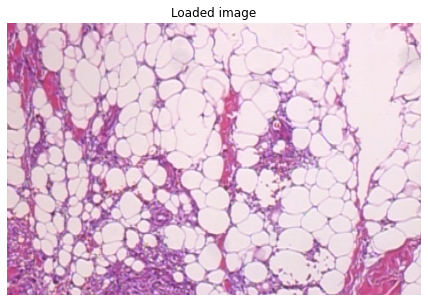

In [31]:
Classify_image(model1,"/content/drive/MyDrive/Data sorted/Data sorted/40X/Holdout set/SOB_M_DC-14-2985-40-005_malignant.png")

# New Section